In [1]:
import random

from IPython.display import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import madmom as mm
import librosa as lr
import mir_eval as me
import mido as md
from librosa.display import waveplot, specshow

%matplotlib inline

In [2]:
sample_rate = 16000
hop_length = 512
top_db = 30

audio_path, annotation_path = random.choice([
    ('/media/carl/Data/solo-instrument-recordings/polyphonic/guitar/akgit3hifi.ogg', '/media/carl/Data/solo-instrument-recordings/polyphonic/guitar/akgit3hifi.csv'),
    ('/media/carl/Data/solo-instrument-recordings/polyphonic/violin/violin05_bachhmoll.ogg', '/media/carl/Data/solo-instrument-recordings/polyphonic/violin/violin05_bachhmoll.csv'),
    ('/media/carl/Data/solo-instrument-recordings/polyphonic/piano/blinka01b.ogg', '/media/carl/Data/solo-instrument-recordings/polyphonic/piano/blinka01b.csv'),
    ('/media/carl/Data/solo-instrument-recordings/polyphonic/piano/Bach1.ogg', '/media/carl/Data/solo-instrument-recordings/polyphonic/piano/Bach1.csv'),
])

audio, _ = lr.load(audio_path, sample_rate)
reference_annotation = pd.read_csv(annotation_path)

Audio(audio, rate=sample_rate)

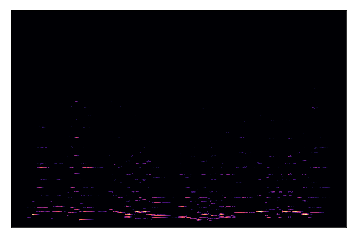

In [3]:
def spectral_transform(audio_samples, sample_rate, hop_length, top_db):
    audio_samples = lr.util.normalize(audio_samples)
    n_fft = hop_length * 2
    z = lr.stft(y=audio, n_fft=n_fft, hop_length=hop_length)
    bands = lr.fft_frequencies(sr=sample_rate, n_fft=n_fft)
    spectrogram = lr.power_to_db(z**2, top_db=top_db)
    return spectrogram, bands


spectrogram, bands = spectral_transform(audio, sample_rate, hop_length, top_db)
specshow(spectrogram);

# Peak Detection

Number of peaks:  3365


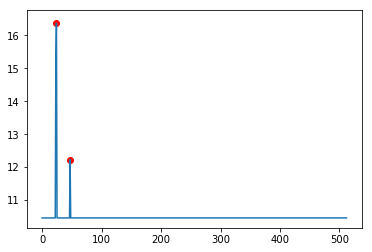

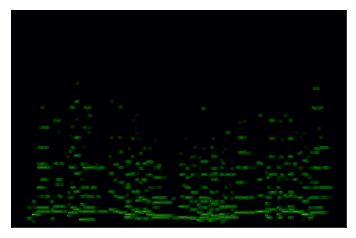

In [4]:
def partials(spectrogram, top_db):
    """Determine spectral peaks."""

    # Go through audio frame-by-frame.
    frames = []
    for spectrum in spectrogram.T:

        # Don't try to pick peaks if overall audio volume is too low.
        if all(spectrum < top_db * 0.1):
            frames.append(([], []))
            continue

        # Pick spectral peaks.
        powers = []
        peaks = []
        dy = 0.01 * top_db
        ys = spectrum
        xs = np.arange(len(spectrum))
        ymin = np.Inf
        ymax = -np.Inf
        uphill = True
        for x, y in zip(xs, ys):

            if y > ymax:
                ymax = y
                xmax = x

            if y < ymin:
                ymin = y
                xmin = x

            if uphill:
                if y < ymax - dy:
                    powers.append(ymax)
                    peaks.append(xmax)
                    ymin = y
                    xmin = x
                    uphill = False
            else:
                if y > ymin + dy:
                    ymax = y
                    xmax = x
                    uphill = True
        
        frames.append((peaks, powers))

    peaks = [x[0] for x in frames]
    powers = [x[1] for x in frames]
    return peaks, powers


peaks, powers = partials(spectrogram, top_db=top_db)

print("Number of peaks: ", sum(len(x) for x in peaks))

frequencies = [list(bands[list(x)]) for x in peaks]

# Plot a frame.
for frame in zip(spectrogram.T, peaks, powers):
    if len(frame[1]) > 1:
        plt.plot(frame[0])
        plt.scatter(frame[1], frame[2], color='r')
        plt.show()
        plt.xlim([0, 100])
        break

# Plot all frames over time.
X, Y = [], []
for x, ys in enumerate(peaks):
    xs = [x] * len(ys)
    X.extend(xs)
    Y.extend(ys)
ax = specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
ax.scatter(X, Y, marker='.', color='g', alpha=0.1);

# Kalman Tracker

914

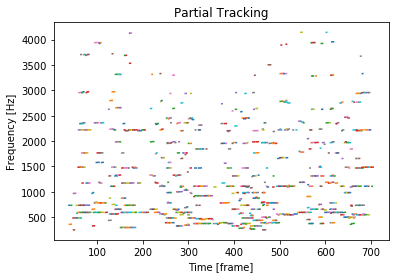

In [5]:
frames = list(zip(powers, frequencies))

tracks = []

# Transition matrix
power_variation = 0.99
frequency_variation = 0.9
A = np.array([[1, 1, 0, 0, 0],
              [0, 1, 1, 0, 0],
              [0, 0, power_variation, 0, 0],
              [0, 0, 0, 1, 1],
              [0, 0, 0, 0, frequency_variation]])

# State matrix
noise_gain = 1
power_gain = 10
frequency_gain = 0.1
B = np.array([[0, 0, 0],
              [0, 0, noise_gain],
              [power_gain, 0, 0],
              [0, 0, 0],
              [0, frequency_gain, 0]])

# Observation matrix
C = np.array([[1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0]])

# Process noise covariance
Q = np.eye(3)

# Measurement noise covariance
R = np.eye(2)

# The process noise and observation noise could be thought of as spectral fluctuations caused by inharmonicity, timbral variations, beats, etc.
initial_v = 1.0
initial_w = 1.0
initial_z = 1.0
alive_tracks = [[(0, np.array([p, initial_v, initial_w, f, initial_z]))]
                for p, f in list(zip(*frames[0]))]

for frame_idx, frame in enumerate(frames[1:], start=1):

    # Kalman filter ongoing tracks.
    next_states = []
    next_observations = []
    for track in alive_tracks:
        x = track[-1][1]
        
        v = np.random.multivariate_normal(np.zeros(len(Q)), Q)
        w = np.random.multivariate_normal(np.zeros(len(R)), R)

        # Estimate observation.
        y = C.dot(x) + w

        # Estimate next state.
        x = A.dot(x) + B.dot(v)
        
        next_observations.append(y)
        next_states.append(x)
    
    # Go through all peaks and assign them to ongoing tracks.
    new_tracks = []
    updated = [False] * len(alive_tracks)
    previous_candidate_distances = {}
    for peak in list(zip(*frame)):
        observation = np.array(peak).T

        # Go through all ongoing tracks and pick the closest to the new observation.
        candidate_track = None
        candidate_distance = np.Inf
        for i, (track, next_state, next_observation) in enumerate(zip(alive_tracks, 
                                                                      next_states, 
                                                                      next_observations)):
            distance = np.sqrt(((observation - next_observation) ** 2).mean())
            if distance < candidate_distance:
                candidate_distance = distance
                candidate_track = track
                candidate_track_i = i
                candidate_peak = (frame_idx, next_state)

        gate = 10.0
        if candidate_track and candidate_distance < gate:
            if not updated[candidate_track_i]:
                # Continue the closest track with the Kalman filtered peak.
                candidate_track.append(candidate_peak)
                updated[candidate_track_i] = True
                previous_candidate_distances[candidate_track_i] = candidate_distance
            else:
                # Pick best fitting candidate peak.
                if candidate_distance < previous_candidate_distances[candidate_track_i]:
                    candidate_track[-1] = candidate_peak
        else:
            # No candidate track was found: add current observation to a new track.
            p, f = observation
            new_track = [(frame_idx, np.array([p, initial_v, initial_w, f, initial_z]))]
            new_tracks.append(new_track)
        
    # Go through non-updated tracks and maybe kill them.
    for i, track in enumerate(alive_tracks):
        if updated[i]:
            continue
        latest_frame_idx = track[-1][0]
        alive_tracks.pop(i)
        tracks.append(track)

    print('Frame: ' + str(frame_idx) + '/' + str(len(frames)) + ', Partial tracks: ' + str(len(tracks)) + '\r', end='')

    # Make sure new tracks are alive.
    alive_tracks += new_tracks

# At the final frame, add all remaining ongoing tracks.
tracks += alive_tracks

_tracks = []
for t in tracks:
    xs = np.array([x[0] for x in t])
    ps = np.array([x[1][0] for x in t])
    fs = np.array([x[1][3] for x in t])

    # Skip partials outside a reasonable frequency range.
    if any(f < 20 for f in fs):
        continue
    if any(f > 20000 for f in fs):
        continue
    if all(f < lr.note_to_hz('A0') for f in fs):
        continue
    if all(f > lr.note_to_hz('C8') for f in fs):
        continue
    
    # Skip short partials.
    if len(xs) <= 1:
        continue

    _tracks.append(t)
    
    plt.plot(xs, fs)

plt.title('Partial Tracking')
plt.xlabel('Time [frame]')
plt.ylabel('Frequency [Hz]')
tracks = _tracks
len(tracks)

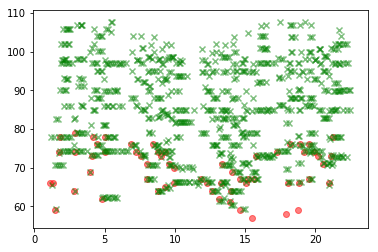

In [6]:
# Convert partials to note events.
events = []
for t in tracks:
    fs = np.array([x[1][3] for x in t])
    note = lr.hz_to_midi(np.median(fs))[0]
    onset, offset = lr.frames_to_time([t[0][0], t[-1][0]],
                                      sr=sample_rate,
                                      hop_length=hop_length)
    events.append((note, onset, offset))
estimated_annotation = pd.DataFrame(events, columns=['Note', 'Onset', 'Offset'])

plt.scatter(reference_annotation.Onset, reference_annotation.Note, marker='o', color='r', alpha=0.5)
plt.scatter(estimated_annotation.Onset, estimated_annotation.Note, marker='x', color='g', alpha=0.5);

In [7]:
# Listen to partials.
synthesis = None
for t in tracks:
    xs = np.array([x[0] for x in t])
    ps = np.array([x[1][0] for x in t])
    fs = np.array([x[1][3] for x in t])

    times = np.array(lr.frames_to_time(xs, sr=sample_rate, hop_length=hop_length))

    a = me.sonify.pitch_contour(times=times, 
                                frequencies=np.array(fs), 
                                fs=sample_rate)   
    if a.size > 0:
        if synthesis is None:
            synthesis = a
        else:
            synthesis = lr.util.fix_length(synthesis, max(synthesis.size, a.size)) 
            synthesis[:a.size] += a

synthesis = lr.util.normalize(synthesis)
Audio(synthesis, rate=sample_rate)